# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0910s1_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5127, 32, 32, 3)
(5127, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/100


C:\Users\Muell\anaconda3\envs\anaconda-win11-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


641/641 [==============================] - 13s 19ms/step - loss: 0.3312 - accuracy: 0.6980 - val_loss: 0.0160 - val_accuracy: 0.9776
Epoch 2/100
641/641 [==============================] - 10s 16ms/step - loss: 0.0218 - accuracy: 0.9650 - val_loss: 0.0091 - val_accuracy: 0.9893
Epoch 3/100
641/641 [==============================] - 10s 16ms/step - loss: 0.0111 - accuracy: 0.9763 - val_loss: 0.0062 - val_accuracy: 0.9893
Epoch 4/100
641/641 [==============================] - 10s 16ms/step - loss: 0.0073 - accuracy: 0.9784 - val_loss: 0.0045 - val_accuracy: 0.9893
Epoch 5/100
641/641 [==============================] - 12s 18ms/step - loss: 0.0051 - accuracy: 0.9819 - val_loss: 0.0025 - val_accuracy: 0.9864
Epoch 6/100
641/641 [==============================] - 14s 22ms/step - loss: 0.0041 - accuracy: 0.9808 - val_loss: 0.0048 - val_accuracy: 0.9805
Epoch 7/100
641/641 [==============================] - 22s 35ms/step - loss: 0.0032 - accuracy: 0.9873 - val_loss: 0.0025 - val_accuracy: 0.99

641/641 [==============================] - 31s 47ms/step - loss: 4.7577e-04 - accuracy: 0.9965 - val_loss: 4.4047e-04 - val_accuracy: 0.9990
Epoch 57/100
641/641 [==============================] - 30s 46ms/step - loss: 4.5943e-04 - accuracy: 0.9961 - val_loss: 4.0418e-04 - val_accuracy: 1.0000
Epoch 58/100
641/641 [==============================] - 29s 45ms/step - loss: 4.4652e-04 - accuracy: 0.9959 - val_loss: 4.9343e-04 - val_accuracy: 0.9951
Epoch 63/100
641/641 [==============================] - 29s 45ms/step - loss: 4.6658e-04 - accuracy: 0.9940 - val_loss: 3.5933e-04 - val_accuracy: 0.9981
Epoch 64/100
641/641 [==============================] - 29s 44ms/step - loss: 3.9574e-04 - accuracy: 0.9958 - val_loss: 7.4695e-04 - val_accuracy: 0.9961
Epoch 65/100
641/641 [==============================] - 30s 47ms/step - loss: 4.4923e-04 - accuracy: 0.9952 - val_loss: 7.6946e-04 - val_accuracy: 1.0000
Epoch 66/100
641/641 [==============================] - 32s 49ms/step - loss: 4.2962e-04 

### Step 1: Learing result
 
* Visualization of the training and validation results

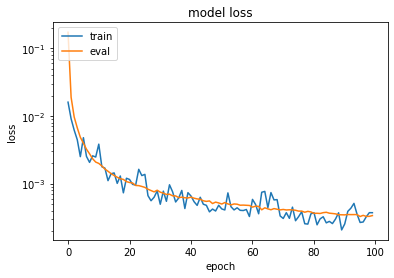

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 400
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


C:\Users\Muell\anaconda3\envs\anaconda-win11-env\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/400
641/641 [==============================] - 33s 52ms/step - loss: 0.0383 - accuracy: 0.9440 - val_loss: 0.0086 - val_accuracy: 0.9834
Epoch 2/400
641/641 [==============================] - 33s 51ms/step - loss: 0.0069 - accuracy: 0.9768 - val_loss: 0.0046 - val_accuracy: 0.9766
Epoch 3/400
641/641 [==============================] - 33s 50ms/step - loss: 0.0045 - accuracy: 0.9828 - val_loss: 0.0033 - val_accuracy: 0.9854
Epoch 4/400
641/641 [==============================] - 33s 52ms/step - loss: 0.0038 - accuracy: 0.9850 - val_loss: 0.0028 - val_accuracy: 0.9854
Epoch 5/400
641/641 [==============================] - 33s 51ms/step - loss: 0.0032 - accuracy: 0.9850 - val_loss: 0.0027 - val_accuracy: 0.9854
Epoch 6/400
641/641 [==============================] - 30s 47ms/step - loss: 0.0029 - accuracy: 0.9856 - val_loss: 0.0021 - val_accuracy: 0.9883
Epoch 7/400
641/641 [==============================] - 29s 45ms/step - loss: 0.0026 - accuracy: 0.9862 - val_loss: 0.0029 - val_ac

641/641 [==============================] - 29s 44ms/step - loss: 7.6263e-04 - accuracy: 0.9936 - val_loss: 7.8997e-04 - val_accuracy: 0.9932
Epoch 56/400
641/641 [==============================] - 30s 47ms/step - loss: 7.4840e-04 - accuracy: 0.9938 - val_loss: 7.2021e-04 - val_accuracy: 0.9942
Epoch 57/400
641/641 [==============================] - 30s 46ms/step - loss: 7.4593e-04 - accuracy: 0.9951 - val_loss: 7.7681e-04 - val_accuracy: 0.9961
Epoch 58/400
641/641 [==============================] - 30s 47ms/step - loss: 7.4390e-04 - accuracy: 0.9943 - val_loss: 6.0841e-04 - val_accuracy: 0.9971
Epoch 59/400
641/641 [==============================] - 31s 48ms/step - loss: 7.2679e-04 - accuracy: 0.9941 - val_loss: 6.9117e-04 - val_accuracy: 0.9971
Epoch 60/400
641/641 [==============================] - 30s 47ms/step - loss: 7.2882e-04 - accuracy: 0.9934 - val_loss: 7.3463e-04 - val_accuracy: 0.9981
Epoch 61/400
641/641 [==============================] - 29s 45ms/step - loss: 7.4707e-04 

641/641 [==============================] - 21s 33ms/step - loss: 5.7721e-04 - accuracy: 0.9947 - val_loss: 4.6870e-04 - val_accuracy: 0.9990
Epoch 108/400
641/641 [==============================] - 21s 32ms/step - loss: 5.6796e-04 - accuracy: 0.9951 - val_loss: 4.9587e-04 - val_accuracy: 1.0000
Epoch 109/400
641/641 [==============================] - 21s 32ms/step - loss: 5.3870e-04 - accuracy: 0.9934 - val_loss: 6.1707e-04 - val_accuracy: 0.9981
Epoch 110/400
641/641 [==============================] - 20s 31ms/step - loss: 5.4568e-04 - accuracy: 0.9940 - val_loss: 4.9192e-04 - val_accuracy: 0.9990
Epoch 111/400
641/641 [==============================] - 21s 33ms/step - loss: 5.6544e-04 - accuracy: 0.9941 - val_loss: 6.0134e-04 - val_accuracy: 0.9961
Epoch 112/400
641/641 [==============================] - 20s 31ms/step - loss: 5.3936e-04 - accuracy: 0.9940 - val_loss: 5.2693e-04 - val_accuracy: 0.9951
Epoch 113/400
641/641 [==============================] - 20s 31ms/step - loss: 5.387

Epoch 160/400
641/641 [==============================] - 10s 16ms/step - loss: 4.7534e-04 - accuracy: 0.9957 - val_loss: 6.7434e-04 - val_accuracy: 0.9990
Epoch 161/400
641/641 [==============================] - 10s 16ms/step - loss: 4.6191e-04 - accuracy: 0.9951 - val_loss: 4.6472e-04 - val_accuracy: 0.9990
Epoch 162/400
641/641 [==============================] - 10s 16ms/step - loss: 4.6838e-04 - accuracy: 0.9955 - val_loss: 4.5863e-04 - val_accuracy: 0.9942
Epoch 163/400
641/641 [==============================] - 10s 16ms/step - loss: 4.4926e-04 - accuracy: 0.9963 - val_loss: 5.0713e-04 - val_accuracy: 0.9971
Epoch 164/400
641/641 [==============================] - 10s 16ms/step - loss: 4.5639e-04 - accuracy: 0.9959 - val_loss: 4.0578e-04 - val_accuracy: 0.9981
Epoch 165/400
641/641 [==============================] - 10s 16ms/step - loss: 4.6744e-04 - accuracy: 0.9945 - val_loss: 4.4249e-04 - val_accuracy: 0.9951
Epoch 166/400
641/641 [==============================] - 10s 16ms/step

Epoch 213/400
641/641 [==============================] - 10s 15ms/step - loss: 4.1118e-04 - accuracy: 0.9965 - val_loss: 4.2309e-04 - val_accuracy: 0.9951
Epoch 214/400
641/641 [==============================] - 10s 15ms/step - loss: 4.0356e-04 - accuracy: 0.9959 - val_loss: 4.1834e-04 - val_accuracy: 0.9990
Epoch 215/400
641/641 [==============================] - 10s 15ms/step - loss: 4.2036e-04 - accuracy: 0.9953 - val_loss: 3.4989e-04 - val_accuracy: 0.9961
Epoch 216/400
641/641 [==============================] - 10s 15ms/step - loss: 4.1923e-04 - accuracy: 0.9955 - val_loss: 3.3393e-04 - val_accuracy: 0.9971
Epoch 217/400
641/641 [==============================] - 10s 15ms/step - loss: 4.1975e-04 - accuracy: 0.9963 - val_loss: 5.3602e-04 - val_accuracy: 0.9981
Epoch 218/400
641/641 [==============================] - 10s 15ms/step - loss: 4.0343e-04 - accuracy: 0.9953 - val_loss: 4.7087e-04 - val_accuracy: 0.9932
Epoch 219/400
641/641 [==============================] - 10s 15ms/step

Epoch 266/400
641/641 [==============================] - 10s 15ms/step - loss: 3.6867e-04 - accuracy: 0.9967 - val_loss: 3.2747e-04 - val_accuracy: 0.9981
Epoch 267/400
641/641 [==============================] - 10s 15ms/step - loss: 3.7771e-04 - accuracy: 0.9953 - val_loss: 2.9450e-04 - val_accuracy: 0.9990
Epoch 268/400
641/641 [==============================] - 9s 15ms/step - loss: 3.7058e-04 - accuracy: 0.9969 - val_loss: 3.6926e-04 - val_accuracy: 0.9981
Epoch 269/400
641/641 [==============================] - 10s 15ms/step - loss: 3.7999e-04 - accuracy: 0.9953 - val_loss: 3.1280e-04 - val_accuracy: 1.0000
Epoch 270/400
641/641 [==============================] - 10s 15ms/step - loss: 3.6458e-04 - accuracy: 0.9959 - val_loss: 5.0580e-04 - val_accuracy: 0.9990
Epoch 271/400
641/641 [==============================] - 10s 15ms/step - loss: 3.6825e-04 - accuracy: 0.9963 - val_loss: 3.4811e-04 - val_accuracy: 0.9990
Epoch 272/400
641/641 [==============================] - 10s 15ms/step 

Epoch 319/400
641/641 [==============================] - 9s 15ms/step - loss: 3.3470e-04 - accuracy: 0.9957 - val_loss: 4.0088e-04 - val_accuracy: 0.9951
Epoch 320/400
641/641 [==============================] - 10s 15ms/step - loss: 3.4407e-04 - accuracy: 0.9953 - val_loss: 3.0396e-04 - val_accuracy: 0.9990
Epoch 321/400
641/641 [==============================] - 10s 15ms/step - loss: 3.4392e-04 - accuracy: 0.9969 - val_loss: 3.4562e-04 - val_accuracy: 0.9981
Epoch 322/400
641/641 [==============================] - 10s 15ms/step - loss: 3.5255e-04 - accuracy: 0.9973 - val_loss: 2.8814e-04 - val_accuracy: 1.0000
Epoch 323/400
641/641 [==============================] - 10s 15ms/step - loss: 3.4696e-04 - accuracy: 0.9959 - val_loss: 3.1481e-04 - val_accuracy: 0.9981
Epoch 324/400
641/641 [==============================] - 10s 16ms/step - loss: 3.4249e-04 - accuracy: 0.9975 - val_loss: 3.5615e-04 - val_accuracy: 1.0000
Epoch 325/400
641/641 [==============================] - 42s 65ms/step 

641/641 [==============================] - 7s 11ms/step - loss: 3.2105e-04 - accuracy: 0.9975 - val_loss: 2.7417e-04 - val_accuracy: 1.0000
Epoch 373/400
641/641 [==============================] - 6s 10ms/step - loss: 3.1295e-04 - accuracy: 0.9977 - val_loss: 2.5063e-04 - val_accuracy: 0.9981
Epoch 374/400
641/641 [==============================] - 7s 11ms/step - loss: 3.3199e-04 - accuracy: 0.9961 - val_loss: 3.3810e-04 - val_accuracy: 0.9971
Epoch 375/400
641/641 [==============================] - 7s 10ms/step - loss: 3.1328e-04 - accuracy: 0.9965 - val_loss: 2.8507e-04 - val_accuracy: 0.9981
Epoch 376/400
641/641 [==============================] - 7s 10ms/step - loss: 3.1899e-04 - accuracy: 0.9977 - val_loss: 2.6302e-04 - val_accuracy: 0.9971
Epoch 377/400
641/641 [==============================] - 7s 10ms/step - loss: 3.1937e-04 - accuracy: 0.9975 - val_loss: 3.0749e-04 - val_accuracy: 0.9981
Epoch 378/400
641/641 [==============================] - 7s 10ms/step - loss: 3.2021e-04 -

### Overall Learing results (Step 1 & Step 2)

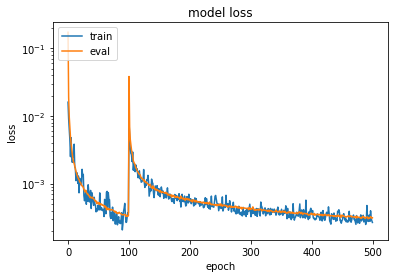

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\6.1_3006_zeiger1_2020-04-29_11-47-02.jpg 0.61 0.7008715427625808 -0.0908715427625808
data_resize_all\6.2_3048_zeiger1_2020-04-29_11-48-02.jpg 0.62 0.7157019704529248 -0.09570197045292483
data_resize_all\6.3_3120_zeiger1_2020-04-29_13-06-02.jpg 0.63 0.7676629191550123 -0.13766291915501228
data_resize_all\6.4_3194_zeiger1_2020-04-29_14-27-02.jpg 0.64 0.7214565945561375 -0.08145659455613752
data_resize_all\6.5_3121_zeiger1_2020-04-29_13-07-02.jpg 0.65 0.7491460865876307 -0.09914608658763069
data_resize_all\6.5_3271_zeiger1_2020-04-29_11-49-17.jpg 0.65 0.7030573171334711 -0.05305731713347106
data_resize_all\6.6_3288_zeiger1_2020-04-29_14-28-02.jpg 0.6599999999999999 0.7260966835687857 -0.06609668356878573
data_resize_all\6.7_3341_zeiger1_2020-04-29_14-29-02.jpg 0.67 0.7322627317057532 -0.06226273170575314
data_resize_all\7.6_3866_zeiger3_2020-04-29_13-31-02.jpg 0.76 0.6963659136128434 0.06363408638715662
data_resize_all\7.7_3914_zeiger3_2020-04-29_12-09-01.jpg 0.77 0.716281

## Results

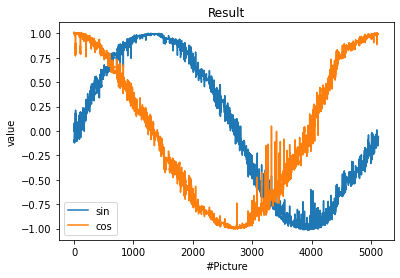

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

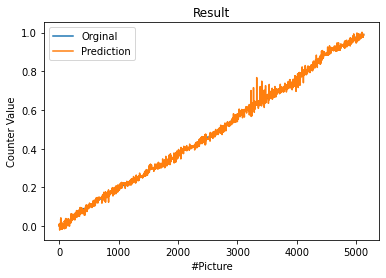

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

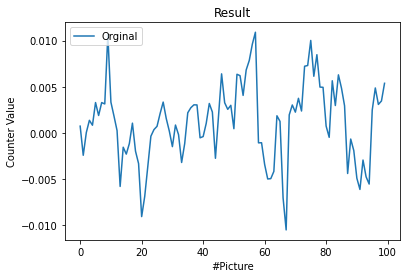

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

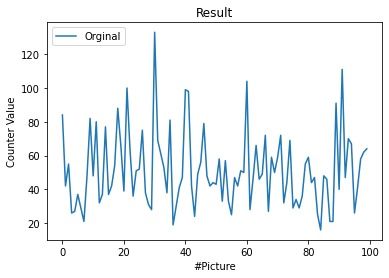

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

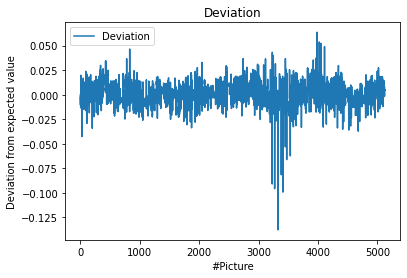

[ 0.0008  0.0105 -0.1377  0.0636]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpml3i3rw0\assets


204360

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpubkfhhld\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpubkfhhld\assets


ana0910s1_longq.tflite


60464